In [ ]:
import pandas as pd
import networkx as nx

# Load the datasets
edges_df = pd.read_csv("/content/sample_data/musae_RU_edges.csv")  # Replace with your edges file path
target_df = pd.read_csv("/content/sample_data/musae_RU_target.csv")  # Replace with your target file path

# Check the loaded data
print("Edges dataset head:\n", edges_df.head())
print("Target dataset head:\n", target_df.head())


Edges dataset head:
    from    to
0     0   646
1     0  2510
2     0  2425
3     0  2596
4     0    85
Target dataset head:
           id  days  mature  views  partner  new_id
0   43622128  1910   False   2002    False    1076
1   32314097  2273    True   1885    False    1090
2  112985248   998   False  14538    False     633
3   54595718  1738    True   8541    False    2238
4   72920173  1461   False  49854    False    1662


In [ ]:
# Create a graph from the edges dataset
G = nx.Graph()
G.add_edges_from(edges_df.values)

# Add node attributes from the target dataset
for index, row in target_df.iterrows():
    node_id = row['id']
    attributes = {
        'new_id': row['new_id'],
        'days': row['days'],
        'mature': row['mature'],
        'views': row['views'],
        'partner': row['partner']
    }
    # Add attributes only if node exists in the graph
    if node_id in G:
        nx.set_node_attributes(G, {node_id: attributes})


In [ ]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# PageRank
pagerank = nx.pagerank(G)

# Store centralities in a dictionary for easy access
centrality_scores = {
    'degree': degree_centrality,
    'betweenness': betweenness_centrality,
    'pagerank': pagerank
}


In [ ]:
# Define a weighting function for each attribute
def calculate_profile_score(node_id):
    # Retrieve centrality measures
    degree = centrality_scores['degree'].get(node_id, 0)
    betweenness = centrality_scores['betweenness'].get(node_id, 0)
    pagerank_score = centrality_scores['pagerank'].get(node_id, 0)

    # Retrieve other features from the graph's node attributes
    node_data = G.nodes[node_id]
    views = node_data.get('views', 0)
    partner = node_data.get('partner', 0)

    # Apply weights (customizable based on importance)
    profile_score = (
        0.3 * degree +        # Degree Centrality weight
        0.3 * betweenness +   # Betweenness Centrality weight
        0.4 * pagerank_score  # PageRank weight
    )

    # Adjust score based on views and partner status
    profile_score += 0.1 * views
    if partner:
        profile_score += 50  # Bonus for partners (arbitrary scaling)

    return profile_score

# Calculate Profile Rank score for each node
profile_scores = {node_id: calculate_profile_score(node_id) for node_id in G.nodes}


In [ ]:
# Sort nodes by profile score in descending order
ranked_influencers = sorted(profile_scores.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 influencers
print("Top 10 Influencers based on Profile Rank Score:")
for rank, (node_id, score) in enumerate(ranked_influencers[:10], start=1):
    print(f"Rank {rank}: Node {node_id}, Profile Rank Score: {score}")


Top 10 Influencers based on Profile Rank Score:
Rank 1: Node 1800, Profile Rank Score: 0.14337722168090175
Rank 2: Node 646, Profile Rank Score: 0.07307475334534373
Rank 3: Node 2425, Profile Rank Score: 0.06362615856450464
Rank 4: Node 1725, Profile Rank Score: 0.058659039721661914
Rank 5: Node 598, Profile Rank Score: 0.05365026798089031
Rank 6: Node 912, Profile Rank Score: 0.050396164652970615
Rank 7: Node 568, Profile Rank Score: 0.04836579162737536
Rank 8: Node 1276, Profile Rank Score: 0.04580138851137656
Rank 9: Node 1916, Profile Rank Score: 0.04446940772147674
Rank 10: Node 208, Profile Rank Score: 0.03753472670541469


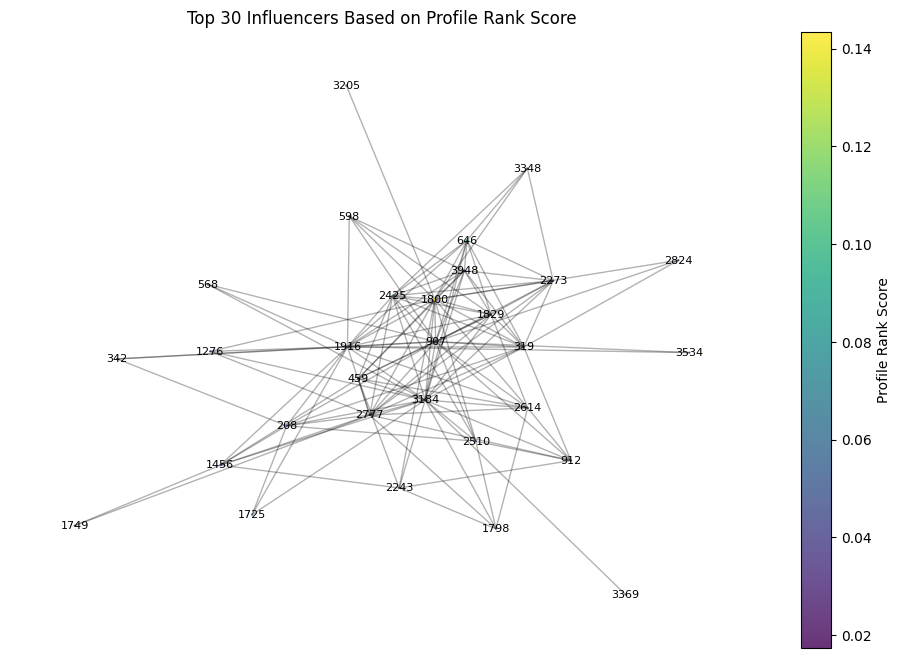

In [ ]:
import matplotlib.pyplot as plt

# Select top N influencers to visualize
N = 30
top_influencers = dict(ranked_influencers[:N])  # Get top N ranked influencers

# Extract subgraph of top influencers
subgraph = G.subgraph(top_influencers.keys())

# Set node sizes based on profile rank scores for visualization
node_sizes = [top_influencers[node] * 10 for node in subgraph.nodes()]  # Scale factor for better visualization

# Set node colors based on rank (higher score = darker color)
node_colors = [top_influencers[node] for node in subgraph.nodes()]

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Use spring layout for better visualization
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
nodes = nx.draw_networkx_nodes(
    subgraph,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.8
)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")

# Add colorbar
plt.colorbar(nodes, label="Profile Rank Score")
plt.title(f"Top {N} Influencers Based on Profile Rank Score")
plt.axis("off")  # Turn off the axis
plt.show()
